In [1]:
import sys
import timeit
import pickle
import codecs
import gensim
import operator
import itertools
import scipy as sp
import numpy as np
import pandas as pd
from konlpy.tag import Okt
from konlpy.tag import Komoran
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import matplotlib.dates as mdates
from matplotlib import font_manager

%matplotlib inline
#plt.rc('text', usetex = True) # use if latex is installed
plt.rcParams['text.latex.unicode'] = True
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams["font.size"] = 20

SMALL_SIZE = 14
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

fm = mpl.font_manager

myeongjo = 'NanumMyeongjo'
gothic = 'NanumGothic'
number = 'DejaVu Sans'

#[(f.name, f.fname) for f in mpl.font_manager.fontManager.ttflist if 'Nanum' in f.name]

# 색 테마
# https://aesalazar.com/blog/3-professional-color-combinations-for-dashboards-or-mobile-bi-applications/

In [2]:
# 국산차게시판 데이터는 natCar
# 수입차게시판 데이터는 intCar
# 뉴스 데이터는 news
natCar = list()
intCar = list()
news = list()

with codecs.open('/home/youngwoo/Documents/Media_BigData/figure/korean.txt', 'r', encoding = 'UTF-8') as fs:
  
    data = eval(fs.read())
    
for d in data:
  
    temp = dict()
    temp['time'] = datetime.strptime(d['time'], '%Y.%m.%d')
    temp['title'] = d['title']
    temp['content'] = d['content']
    temp['reply'] = d['reply']
    natCar.append(temp)

with codecs.open('/home/youngwoo/Documents/Media_BigData/figure/international.txt', 'r', encoding = 'UTF-8') as fs:
  
    data = eval(fs.read())
    
for d in data:
  
    temp = dict()
    temp['time'] = datetime.strptime(d['time'], '%Y.%m.%d')
    temp['title'] = d['title']
    temp['content'] = d['content']
    temp['reply'] = d['reply']
    
    temp['content'] = temp['content'].replace('오토뷰', '')
    temp['content'] = temp['content'].replace('모터그래프', '')
    temp['content'] = temp['content'].replace('카미디어', '')
    temp['content'] = temp['content'].replace('기자', '')
    temp['content'] = temp['content'].replace('뉴스팀', '')
    
    intCar.append(temp)

with open('/home/youngwoo/Documents/Media_BigData/figure/news.pickle', 'rb') as fs:
  
    data = pickle.load(fs)

for d in data:
  
    if d['time'] >= datetime.strptime('2016-01-01', '%Y-%m-%d'):
        
        news.append(d)

In [3]:
df_nat = pd.DataFrame(natCar)
df_nat['len_reply'] = df_nat['reply'].map(len)
df_nat = df_nat[['title', 'content', 'time', 'reply', 'len_reply']]
df_int = pd.DataFrame(intCar)
df_int['len_reply'] = df_int['reply'].map(len)
df_int = df_int[['title', 'content', 'time', 'reply', 'len_reply']]
df_news = pd.DataFrame(news)
df_news = df_news[['title', 'content', 'time']]

#df_bmw = df_int.loc[df_int['content'].str.contains('BMW|bmw|화재|불|리콜|520d|520D')]
df_bmw = df_int.loc[(df_int['content'].str.contains('리콜') & df_int['content'].str.contains('비엠|BMW|bmw')) |
                   df_int['content'].str.contains('불|화재|520d|520D')]

#df_news_bmw = df_news.loc[df_news['content'].str.contains('화재|520d|520D')]
df_news_bmw = df_news.loc[(df_news['content'].str.contains('리콜') & df_news['content'].str.contains('비엠더블유|BMW|bmw')) |
                          df_news['content'].str.contains('화재|520d|520D')]
df_news_bmw = df_news_bmw.loc[~df_news_bmw['content'].str.contains('프로모션|이벤트|출시|모터쇼')]

df_nat_bmw = df_nat.loc[df_nat['content'].str.contains('화재|불|리콜|520d|520D')]

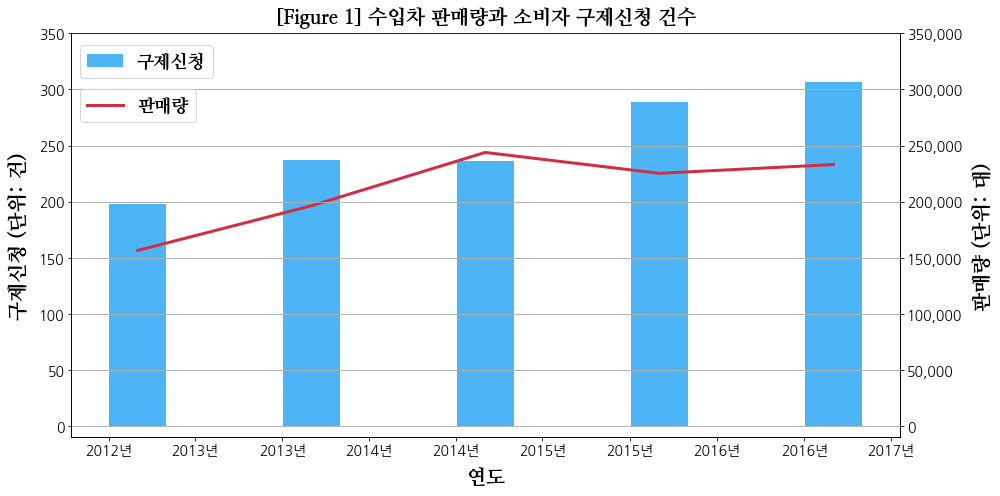

In [4]:
KAIDA_x = [i for i in range(1987, 2018)]
KAIDA_dom_sale = [249448, 323561, 514484, 626126, 772548, 876262, 1037488, 1140399, 1149409, 1238940, 1151287, 568063,
                 910725, 1057620, 1065161, 1225210, 1001874, 857977, 913550, 935681, 986416, 958854, 1174743, 1217764,
                 1211284, 1175891, 1137027, 1213943, 1326776, 1343379, 1296904]
KAIDA_imp_sale = [10, 263, 1293, 2325, 1736, 1817, 1987, 3865, 6921, 10315, 8136, 2075, 2401, 4414, 7747, 16119, 19481,
                  23345, 30901, 40530, 53390, 61648, 60993, 90562, 105037, 130858, 156497, 196359, 243900, 225279, 233088]

x = [i for i in range(2013, 2018)]
sobija_dom = [615, 668, 446, 489, 527]
sobija_imp = [198, 237, 236, 289, 307]

fig, ax = plt.subplots(1, 1, figsize = (14, 7), sharex = True)
ax2 = ax.twinx()

ax2.plot(pd.to_datetime(KAIDA_x[26:], format = '%Y'), KAIDA_imp_sale[26:],
        label = '판매량', color = '#D32D41', lw = 3, zorder = 1)

ax.bar(mdates.date2num(pd.to_datetime(x, format = '%Y')), sobija_imp,
        label = '구제신청', color = '#4CB5F5', width = 120, zorder = 0)


ax.set_title(r'[Figure 1] 수입차 판매량과 소비자 구제신청 건수', fontsize = 20, fontname = myeongjo, pad = 10)
ax.set_xlabel('연도', fontsize = 20, fontname = myeongjo, labelpad = 10)
ax.set_ylabel('구제신청 (단위: 건)', fontsize = 20, fontname = myeongjo, labelpad = 10)
ax.legend(loc = (0.01, 0.89), prop = {'family' : myeongjo, 'size' : 18})
ax.grid(axis = 'y')

ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년'))
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.set_ylim(-10, 350)
ax.set_yticks(np.arange(0, 350 + 1, 50))

ax2.set_ylabel('판매량 (단위: 대)', fontsize = 20, fontname = myeongjo, labelpad = 10)
ax2.legend(loc = (0.01, 0.78), prop = {'family' : myeongjo, 'size' : 18})
ax2.grid(axis = 'y')

ax2.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년'))
ax2.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

ax2.set_ylim(-10000, 350000)
ax2.set_yticks(np.arange(0, 350000 + 1, 50000))

fig.tight_layout()
plt.show()

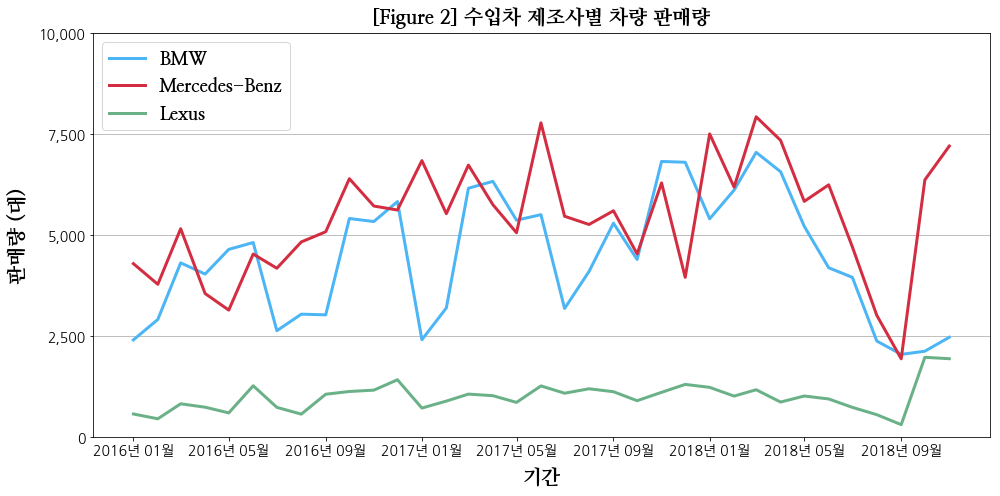

In [5]:
import_car_sales = pd.read_csv('/home/youngwoo/Documents/Media_BigData/figure/auto_import_sales_2016.csv', header=0, index_col=0)
import_car_sales = import_car_sales.transpose()
import_car_sales['imported_total'] = import_car_sales.sum(axis=1)

fig, ax = plt.subplots(1, 1, figsize = (14, 7))

ax.plot(pd.to_datetime(import_car_sales.T.keys(), format = '%Y%m'), import_car_sales['BMW'],
        label = 'BMW', color = '#4CB5F5', lw = 3)
ax.plot(pd.to_datetime(import_car_sales.T.keys(), format = '%Y%m'), import_car_sales['Mercedes-Benz'],
        label = 'Mercedes-Benz', color = '#D32D41', lw = 3)
ax.plot(pd.to_datetime(import_car_sales.T.keys(), format = '%Y%m'), import_car_sales['Lexus'],
        label = 'Lexus', color = '#6AB187', lw = 3)

ax.set_title(r'[Figure 2] 수입차 제조사별 차량 판매량', fontsize = 20, fontname = myeongjo, pad = 10)
ax.set_xlabel('기간', fontsize = 20, fontname = myeongjo, labelpad = 10)
ax.set_ylabel('판매량 (대)', fontsize = 20, fontname = myeongjo, labelpad = 10)
ax.legend(loc = 'upper left', prop = {'family' : myeongjo, 'size' : 18})
ax.grid(axis = 'y')

ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.set_ylim(0, 10000)
ax.set_yticks(np.arange(0, 10000 + 1, 2500))

fig.tight_layout()
plt.tight_layout()
plt.show()

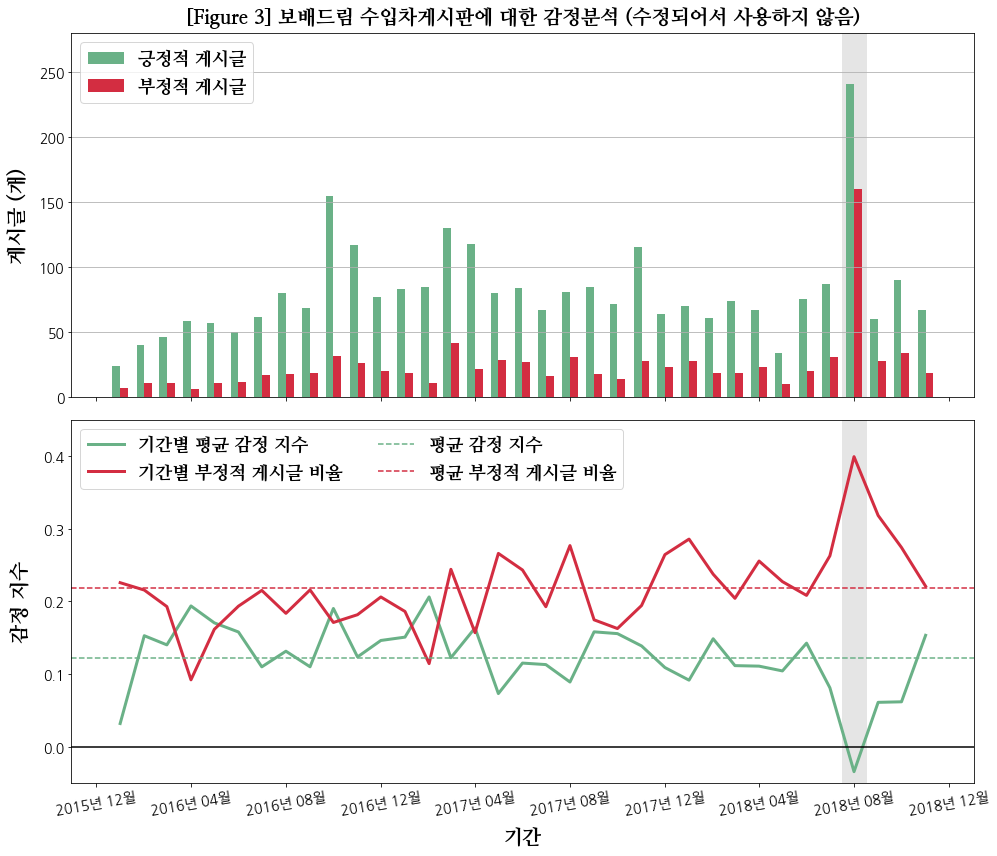

In [6]:
pd_series = pd.read_csv('/home/youngwoo/Documents/Media_BigData/figure/sa_result.csv', header=0, index_col=0)
pd_series = pd_series.transpose()
pd_series['negative_percent'] = pd_series['count_negative'] / pd_series['count']

fig, ax = plt.subplots(2, 1, figsize = (14, 12), sharex = True)

ax[0].axvline(x = mdates.date2num(pd.to_datetime(pd_series['count_positive'].T.keys()[-4], format = '%Y-%m')),
              color = 'gray', lw = 25, alpha = 0.2, zorder = 0)
ax[0].bar(mdates.date2num(pd.to_datetime(pd_series['count_positive'].T.keys(), format = '%Y-%m')) - 5,
        pd_series['count_positive'].T.values, label = '긍정적 게시글', color = '#6AB187', width = 10, zorder = 1)
ax[0].bar(mdates.date2num(pd.to_datetime(pd_series['count_negative'].T.keys(), format = '%Y-%m')) + 5,
        pd_series['count_negative'].T.values, label = '부정적 게시글', color = '#D32D41', width = 10, zorder = 1)

ax[1].axvline(x = mdates.date2num(pd.to_datetime(pd_series['count_positive'].T.keys()[-4], format = '%Y-%m')),
              color = 'gray', lw = 25, alpha = 0.2, zorder = 0)
ax[1].plot(pd.to_datetime(pd_series['sa_score_avg'].T.keys(), format = '%Y-%m'),
         pd_series['sa_score_avg'].T.values, label = '기간별 평균 감정 지수', color = '#6AB187', lw = 3, zorder = 1)
ax[1].plot(pd.to_datetime(pd_series['negative_percent'].T.keys(), format = '%Y-%m'),
         pd_series['negative_percent'].T.values, label = '기간별 부정적 게시글 비율', color = '#D32D41', lw = 3, zorder = 1)

ax[1].set_xlim(ax[1].get_xlim())
ax[1].plot(ax[1].get_xlim(), [pd_series['sa_score_avg'].T.mean(), pd_series['sa_score_avg'].T.mean()],
         color = '#6AB187', linestyle = '--', label = '평균 감정 지수')
ax[1].plot(ax[1].get_xlim(), [pd_series['negative_percent'].T.mean(), pd_series['negative_percent'].T.mean()],
         c = '#D32D41', linestyle = '--', label = '평균 부정적 게시글 비율')
ax[1].plot(ax[1].get_xlim(), [0, 0], c = 'k', linestyle = '-')

ax[0].set_title(r'[Figure 3] 보배드림 수입차게시판에 대한 감정분석 (수정되어서 사용하지 않음)', fontsize = 20, fontname = myeongjo, pad = 10)
ax[0].set_ylabel('게시글 (개)', fontsize = 20, fontname = myeongjo, labelpad = 10)
ax[0].legend(loc = 'upper left', prop = {'family' : myeongjo, 'size' : 18})

ax[1].set_xlabel('기간', fontsize = 20, fontname = myeongjo, labelpad = 10)
ax[1].set_ylabel('감정 지수', fontsize = 20, fontname = myeongjo, labelpad = 10)
ax[1].legend(loc = 'upper left', prop = {'family' : myeongjo, 'size' : 18}, ncol = 2)

ax[0].grid(axis = 'y')

ax[0].get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax[0].get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

ax[0].set_ylim(0, 280)
ax[0].set_yticks(np.arange(0, 250 + 1, 50))

ax[1].set_ylim(-0.05, 0.45)

plt.xticks(rotation = 10)
plt.tight_layout()
plt.show()

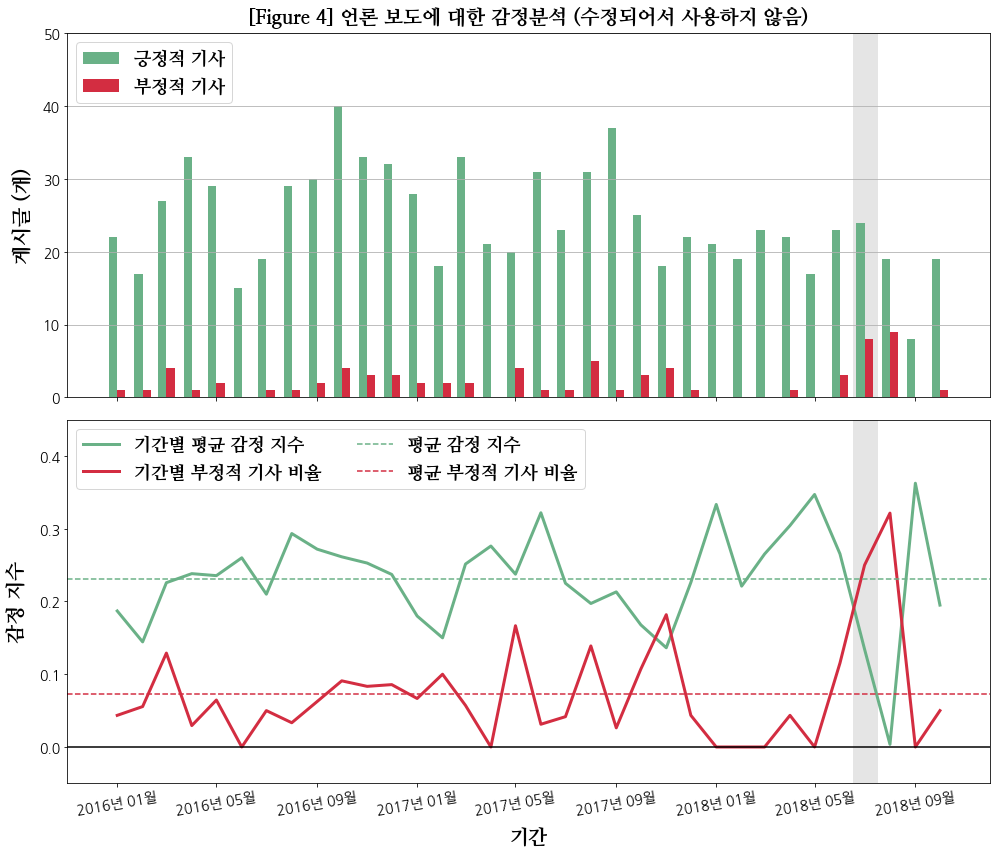

In [7]:
pd_series = pd.read_csv('/home/youngwoo/Documents/Media_BigData/figure/sa_list_news.csv', header=0, index_col=0)
pd_series = pd_series.transpose()
pd_series['negative_percent'] = pd_series['count_negative'] / pd_series['count']

fig, ax = plt.subplots(2, 1, figsize = (14, 12), sharex = True)

ax[0].axvline(x = mdates.date2num(pd.to_datetime(pd_series['count_positive'].T.keys()[-4], format = '%Y-%m')),
              color = 'gray', lw = 25, alpha = 0.2, zorder = 0)
ax[0].bar(mdates.date2num(pd.to_datetime(pd_series['count_positive'].T.keys(), format = '%Y-%m')) - 5,
        pd_series['count_positive'].T.values, label = '긍정적 기사', color = '#6AB187', width = 10, zorder = 1)
ax[0].bar(mdates.date2num(pd.to_datetime(pd_series['count_negative'].T.keys(), format = '%Y-%m')) + 5,
        pd_series['count_negative'].T.values, label = '부정적 기사', color = '#D32D41', width = 10, zorder = 1)

ax[1].axvline(x = mdates.date2num(pd.to_datetime(pd_series['count_positive'].T.keys()[-4], format = '%Y-%m')),
              color = 'gray', lw = 25, alpha = 0.2, zorder = 0)
ax[1].plot(pd.to_datetime(pd_series['sa_score_avg'].T.keys(), format = '%Y-%m'),
         pd_series['sa_score_avg'].T.values, label = '기간별 평균 감정 지수', color = '#6AB187', lw = 3, zorder = 1)
ax[1].plot(pd.to_datetime(pd_series['negative_percent'].T.keys(), format = '%Y-%m'),
         pd_series['negative_percent'].T.values, label = '기간별 부정적 기사 비율', color = '#D32D41', lw = 3, zorder = 1)

ax[1].set_xlim(ax[1].get_xlim())
ax[1].plot(ax[1].get_xlim(), [pd_series['sa_score_avg'].T.mean(), pd_series['sa_score_avg'].T.mean()],
         color = '#6AB187', linestyle = '--', label = '평균 감정 지수')
ax[1].plot(ax[1].get_xlim(), [pd_series['negative_percent'].T.mean(), pd_series['negative_percent'].T.mean()],
         c = '#D32D41', linestyle = '--', label = '평균 부정적 기사 비율')
ax[1].plot(ax[1].get_xlim(), [0, 0], c = 'k', linestyle = '-')

ax[0].set_title(r'[Figure 4] 언론 보도에 대한 감정분석 (수정되어서 사용하지 않음)', fontsize = 20, fontname = myeongjo, pad = 10)
ax[0].set_ylabel('게시글 (개)', fontsize = 20, fontname = myeongjo, labelpad = 10)
ax[0].legend(loc = 'upper left', prop = {'family' : myeongjo, 'size' : 18})

ax[1].set_xlabel('기간', fontsize = 20, fontname = myeongjo, labelpad = 10)
ax[1].set_ylabel('감정 지수', fontsize = 20, fontname = myeongjo, labelpad = 10)
ax[1].legend(loc = 'upper left', prop = {'family' : myeongjo, 'size' : 18}, ncol = 2)

ax[0].grid(axis = 'y')

ax[1].get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax[0].get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

ax[0].set_ylim(0, 50)
ax[0].set_yticks(np.arange(0, 50 + 1, 10))

ax[1].set_ylim(-0.05, 0.45)

plt.xticks(rotation = 10)
plt.tight_layout()
plt.show()

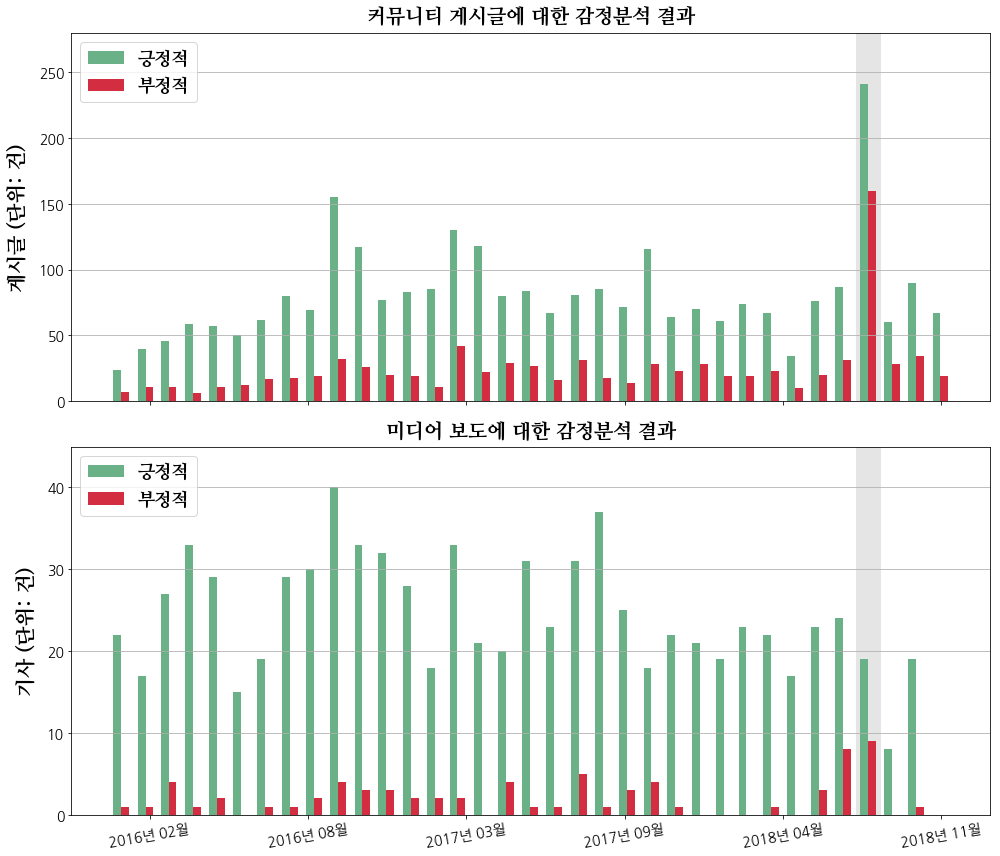

In [8]:
pd_series = pd.read_csv('/home/youngwoo/Documents/Media_BigData/figure/sa_result.csv', header=0, index_col=0)
pd_series = pd_series.transpose()
pd_series['negative_percent'] = pd_series['count_negative'] / pd_series['count']

pd_series2 = pd.read_csv('/home/youngwoo/Documents/Media_BigData/figure/sa_list_news.csv', header=0, index_col=0)
pd_series2 = pd_series2.transpose()
pd_series2['negative_percent'] = pd_series2['count_negative'] / pd_series2['count']

fig, ax = plt.subplots(2, 1, figsize = (14, 12), sharex = True)

ax[0].axvline(x = mdates.date2num(pd.to_datetime(pd_series['count_positive'].T.keys()[-4], format = '%Y-%m')),
              color = 'gray', lw = 25, alpha = 0.2, zorder = 0)
ax[0].bar(mdates.date2num(pd.to_datetime(pd_series['count_positive'].T.keys(), format = '%Y-%m')) - 5,
        pd_series['count_positive'].T.values, label = '긍정적', color = '#6AB187', width = 10, zorder = 1)
ax[0].bar(mdates.date2num(pd.to_datetime(pd_series['count_negative'].T.keys(), format = '%Y-%m')) + 5,
        pd_series['count_negative'].T.values, label = '부정적', color = '#D32D41', width = 10, zorder = 1)

ax[0].set_title(r'커뮤니티 게시글에 대한 감정분석 결과', fontsize = 20, fontname = myeongjo, pad = 10)
ax[0].set_ylabel('게시글 (단위: 건)', fontsize = 20, fontname = myeongjo, labelpad = 10)
ax[0].legend(loc = 'upper left', prop = {'family' : myeongjo, 'size' : 18})

ax[0].grid(axis = 'y')
ax[0].get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax[0].get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

ax[0].set_ylim(0, 280)
ax[0].set_yticks(np.arange(0, 250 + 1, 50))

ax[1].axvline(x = mdates.date2num(pd.to_datetime(pd_series2['count_positive'].T.keys()[-3], format = '%Y-%m')),
              color = 'gray', lw = 25, alpha = 0.2, zorder = 0)
ax[1].bar(mdates.date2num(pd.to_datetime(pd_series2['count_positive'].T.keys(), format = '%Y-%m')) - 5,
        pd_series2['count_positive'].T.values, label = '긍정적', color = '#6AB187', width = 10, zorder = 1)
ax[1].bar(mdates.date2num(pd.to_datetime(pd_series2['count_negative'].T.keys(), format = '%Y-%m')) + 5,
        pd_series2['count_negative'].T.values, label = '부정적', color = '#D32D41', width = 10, zorder = 1)


ax[1].set_title(r'미디어 보도에 대한 감정분석 결과', fontsize = 20, fontname = myeongjo, pad = 10)
ax[1].set_ylabel('기사 (단위: 건)', fontsize = 20, fontname = myeongjo, labelpad = 10)
ax[1].legend(loc = 'upper left', prop = {'family' : myeongjo, 'size' : 18})

ax[1].grid(axis = 'y')
ax[1].get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

ax[1].set_ylim(0, 45)
ax[1].set_yticks(np.arange(0, 45 + 1, 10))

plt.xticks(rotation = 10)
plt.tight_layout()
plt.show()

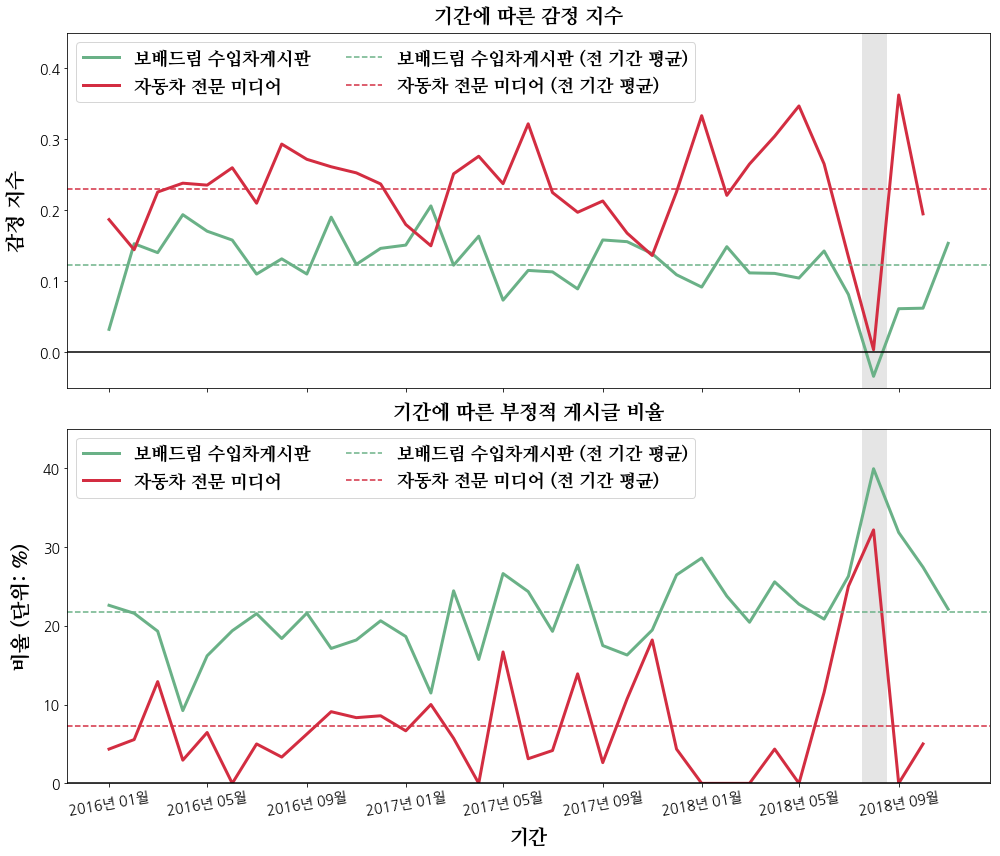

In [9]:
pd_series = pd.read_csv('/home/youngwoo/Documents/Media_BigData/figure/sa_list_news.csv', header=0, index_col=0)
pd_series = pd_series.transpose()
pd_series['negative_percent'] = pd_series['count_negative'] / pd_series['count']

pd_series2 = pd.read_csv('/home/youngwoo/Documents/Media_BigData/figure/sa_result.csv', header=0, index_col=0)
pd_series2 = pd_series2.transpose()
pd_series2['negative_percent'] = pd_series2['count_negative'] / pd_series2['count']


fig, ax = plt.subplots(2, 1, figsize = (14, 12), sharex = True)

ax[0].axvline(x = mdates.date2num(pd.to_datetime(pd_series['count_positive'].T.keys()[-3], format = '%Y-%m')),
              color = 'gray', lw = 25, alpha = 0.2, zorder = 0)
ax[0].plot(pd.to_datetime(pd_series2['sa_score_avg'].T.keys(), format = '%Y-%m'),
         pd_series2['sa_score_avg'].T.values, label = '보배드림 수입차게시판', color = '#6AB187', lw = 3, zorder = 1)
ax[0].plot(pd.to_datetime(pd_series['sa_score_avg'].T.keys(), format = '%Y-%m'),
         pd_series['sa_score_avg'].T.values, label = '자동차 전문 미디어', color = '#D32D41', lw = 3, zorder = 1)

ax[0].set_xlim(ax[1].get_xlim())
ax[0].plot(ax[1].get_xlim(), [pd_series2['sa_score_avg'].T.mean(), pd_series2['sa_score_avg'].T.mean()],
         c = '#6AB187', linestyle = '--', label = '보배드림 수입차게시판 (전 기간 평균)')
ax[0].plot(ax[1].get_xlim(), [pd_series['sa_score_avg'].T.mean(), pd_series['sa_score_avg'].T.mean()],
         c = '#D32D41', linestyle = '--', label = '자동차 전문 미디어 (전 기간 평균)')
ax[0].plot(ax[1].get_xlim(), [0, 0], c = 'k', linestyle = '-')

ax[0].set_title(r'기간에 따른 감정 지수', fontsize = 20, fontname = myeongjo, pad = 10)
ax[0].set_ylabel('감정 지수', fontsize = 20, fontname = myeongjo, labelpad = 10)
ax[0].legend(loc = 'upper left', prop = {'family' : myeongjo, 'size' : 18}, ncol = 2)
ax[0].get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax[0].set_ylim(-0.05, 0.45)




ax[1].axvline(x = mdates.date2num(pd.to_datetime(pd_series['count_positive'].T.keys()[-3], format = '%Y-%m')),
              color = 'gray', lw = 25, alpha = 0.2, zorder = 0)
ax[1].plot(pd.to_datetime(pd_series2['negative_percent'].T.keys(), format = '%Y-%m'),
         pd_series2['negative_percent'].T.values * 100, label = '보배드림 수입차게시판', color = '#6AB187', lw = 3, zorder = 1)
ax[1].plot(pd.to_datetime(pd_series['negative_percent'].T.keys(), format = '%Y-%m'),
         pd_series['negative_percent'].T.values * 100, label = '자동차 전문 미디어', color = '#D32D41', lw = 3, zorder = 1)

ax[1].set_xlim(ax[1].get_xlim())
ax[1].plot(ax[1].get_xlim(), [pd_series2['negative_percent'].T.mean() * 100, pd_series2['negative_percent'].T.mean() * 100],
         c = '#6AB187', linestyle = '--', label = '보배드림 수입차게시판 (전 기간 평균)')
ax[1].plot(ax[1].get_xlim(), [pd_series['negative_percent'].T.mean() * 100, pd_series['negative_percent'].T.mean() * 100],
         c = '#D32D41', linestyle = '--', label = '자동차 전문 미디어 (전 기간 평균)')
ax[1].plot(ax[1].get_xlim(), [0, 0], c = 'k', linestyle = '-')

ax[1].set_title(r'기간에 따른 부정적 게시글 비율', fontsize = 20, fontname = myeongjo, pad = 10)
ax[1].set_xlabel('기간', fontsize = 20, fontname = myeongjo, labelpad = 10)
ax[1].set_ylabel('비율 (단위: %)', fontsize = 20, fontname = myeongjo, labelpad = 10)
ax[1].legend(loc = 'upper left', prop = {'family' : myeongjo, 'size' : 18}, ncol = 2)
ax[1].get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax[1].set_ylim(0, 45)
ax[1].set_yticks(np.arange(0, 45 + 1, 10))

plt.xticks(rotation = 10)
plt.tight_layout()
plt.show()

In [10]:
x_nat_year = df_nat['title'].groupby([df_nat["time"].dt.year.rename('year'),
                                  df_nat["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 0)
x_nat_month = df_nat['title'].groupby([df_nat["time"].dt.year.rename('year'),
                                   df_nat["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 1)
x_nat_date = pd.DataFrame(x_nat_year, x_nat_month)
x_nat_date['date'] = pd.to_datetime(x_nat_date['year'].astype(int).astype(str) + '-' + x_nat_date.index.astype(int).astype(str))
y_nat = df_nat['title'].groupby([df_nat["time"].dt.year.rename('year'), df_nat["time"].dt.month.rename('month')]).count().T[1:].values

x_int_year = df_int['title'].groupby([df_int["time"].dt.year.rename('year'),
                                  df_int["time"].dt.month.rename('month')]).count().T[18:].index.get_level_values(level = 0)
x_int_month = df_nat['title'].groupby([df_int["time"].dt.year.rename('year'),
                                   df_int["time"].dt.month.rename('month')]).count().T[18:].index.get_level_values(level = 1)
x_int_date = pd.DataFrame(x_int_year, x_int_month)
x_int_date['date'] = pd.to_datetime(x_int_date['year'].astype(int).astype(str) + '-' + x_int_date.index.astype(int).astype(str))
y_int = df_int['title'].groupby([df_int["time"].dt.year.rename('year'), df_int["time"].dt.month.rename('month')]).count().T[18:].values

x_bmw_year = df_bmw['title'].groupby([df_bmw["time"].dt.year.rename('year'),
                                  df_bmw["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 0)
x_bmw_month = df_bmw['title'].groupby([df_bmw["time"].dt.year.rename('year'),
                                   df_bmw["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 1)
x_bmw_date = pd.DataFrame(x_bmw_year, x_bmw_month)
x_bmw_date['date'] = pd.to_datetime(x_bmw_date['year'].astype(int).astype(str) + '-' + x_bmw_date.index.astype(int).astype(str))
y_bmw = df_bmw['title'].groupby([df_bmw["time"].dt.year.rename('year'), df_bmw["time"].dt.month.rename('month')]).count().T[1:].values
y_bmw_ratio = y_bmw[17:] / y_int * 100

x_nat_bmw_year = df_nat_bmw['title'].groupby([df_nat_bmw["time"].dt.year.rename('year'),
                                              df_nat_bmw["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 0)
x_nat_bmw_month = df_nat_bmw['title'].groupby([df_nat_bmw["time"].dt.year.rename('year'),
                                               df_nat_bmw["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 1)
x_nat_bmw_date = pd.DataFrame(x_nat_bmw_year, x_nat_bmw_month)
x_nat_bmw_date['date'] = pd.to_datetime(x_nat_bmw_date['year'].astype(int).astype(str) + '-' +
                                        x_nat_bmw_date.index.astype(int).astype(str))
y_nat_bmw = df_nat_bmw['title'].groupby([df_nat_bmw["time"].dt.year.rename('year'),
                                         df_nat_bmw["time"].dt.month.rename('month')]).count().T[1:].values

x_news_bmw_year = df_news_bmw['title'].groupby([df_news_bmw["time"].dt.year.rename('year'),
                                  df_news_bmw["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 0)
x_news_bmw_month = df_news_bmw['title'].groupby([df_news_bmw["time"].dt.year.rename('year'),
                                   df_news_bmw["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 1)
x_news_bmw_date = pd.DataFrame(x_news_bmw_year, x_news_bmw_month)
x_news_bmw_date['date'] = pd.to_datetime(x_news_bmw_date['year'].astype(int).astype(str) + '-' +
                                         x_news_bmw_date.index.astype(int).astype(str))
y_news_bmw = df_news_bmw['title'].groupby([df_news_bmw["time"].dt.year.rename('year'),
                                           df_news_bmw["time"].dt.month.rename('month')]).count().T[1:].values

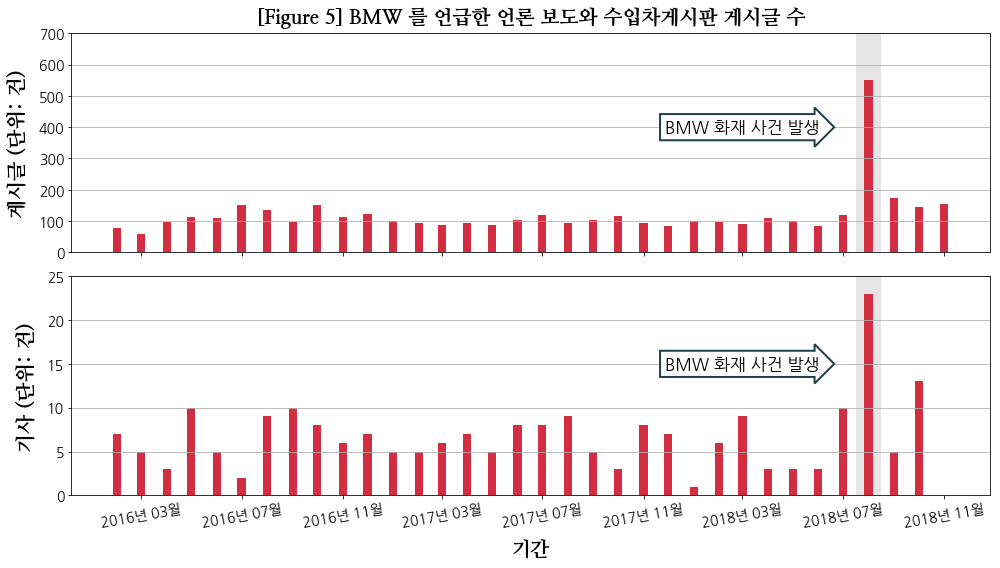

In [11]:
fig, ax = plt.subplots(2, 1, figsize = (14, 8), sharex = True)

ax[0].bar(x_bmw_date['date'].values, y_bmw, label = '보배드림 수입차게시판', width = 10, color = '#D32D41', zorder = 1)
ax[0].axvline(x = mdates.date2num(x_bmw_date['date'].values)[-4],
           color = 'gray', lw = 25, alpha = 0.2, zorder = 0)

ax[1].bar(x_news_bmw_date['date'].values, y_news_bmw, label = '언론 보도', width = 10, color = '#D32D41', zorder = 1)
ax[1].axvline(x = mdates.date2num(x_news_bmw_date['date'].values)[-3],
           color = 'gray', lw = 25, alpha = 0.2, zorder = 0)

ax[0].set_title(r'[Figure 5] BMW 를 언급한 언론 보도와 수입차게시판 게시글 수', fontsize = 20, fontname = myeongjo, pad = 10)
ax[0].set_ylabel('게시글 (단위: 건)', fontsize = 20, fontname = myeongjo, labelpad = 10)
#ax[0].legend(loc = 'upper left', prop = {'family' : myeongjo, 'size' : 18})
ax[0].grid(axis = 'y')

ax[1].set_ylabel('기사 (단위: 건)', fontsize = 20, fontname = myeongjo, labelpad = 10)
#ax[1].legend(loc = 'upper left', prop = {'family' : myeongjo, 'size' : 18})
ax[1].grid(axis = 'y')

ax[0].get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax[0].get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1].get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax[1].get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

ax[1].set_xlabel('기간', fontsize = 20, fontname = myeongjo, labelpad = 10)

ax[0].set_ylim(0, 700)
ax[0].set_yticks(np.arange(0, 700 + 1, 100))
ax[1].set_ylim(0, 25)
ax[1].set_yticks(np.arange(0, 25 + 1, 5))

ax[0].text(mdates.date2num(x_bmw_date['date'].values[-9]), 400,
           'BMW 화재 사건 발생', ha = 'center', va = 'center', rotation = 0, size = 17,
           bbox = dict(boxstyle = 'rarrow', fc = (1, 1, 1), ec = '#1F3F49', lw = 2))

ax[1].text(mdates.date2num(x_news_bmw_date['date'].values[-8]), 15,
           'BMW 화재 사건 발생', ha = 'center', va = 'center', rotation = 0, size = 17,
           bbox = dict(boxstyle = 'rarrow', fc = (1, 1, 1), ec = '#1F3F49', lw = 2))

plt.xticks(rotation = 10)
plt.tight_layout()
plt.show()

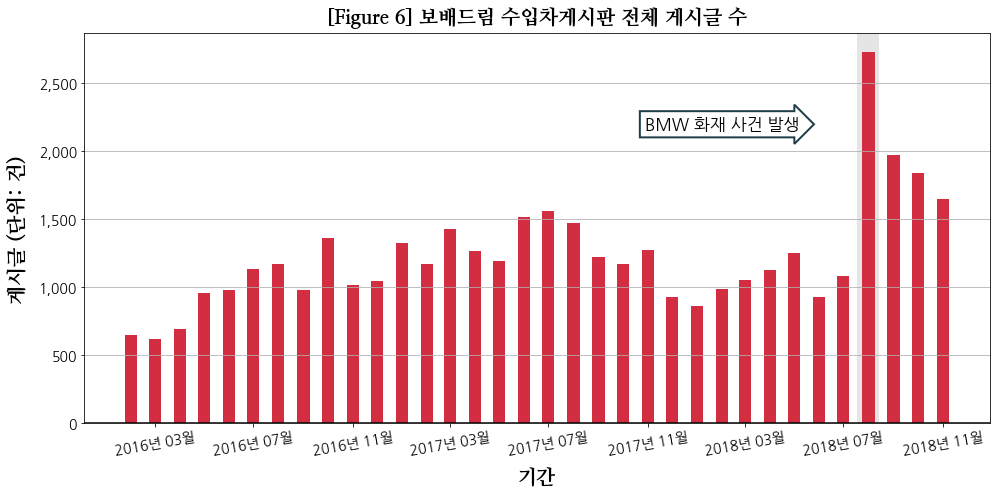

In [12]:
y_int = df_int['title'].groupby([df_int["time"].dt.year.rename('year'), df_int["time"].dt.month.rename('month')]).count().T.values

fig, ax = plt.subplots(1, 1, figsize = (14, 7))

ax.bar(x_bmw_date['date'].values, y_int[1:], label = '수입차',
       width = 15, color = '#D32D41', zorder = 1)
#ax.bar(x_bmw_date['date'].values, (y_int[1:] - y_int[:-1]) / y_int[1:] * 100, label = '수입차',
#       width = 15, color = '#D32D41', zorder = 1)
ax.axvline(x = mdates.date2num(x_int_date['date'].values)[-4],
          color = 'gray', lw = 22, alpha = 0.2, zorder = 0)
ax.axhline(y = 0, color = 'k')

ax.set_title(r'[Figure 6] 보배드림 수입차게시판 전체 게시글 수', fontsize = 20, fontname = myeongjo, pad = 10)
ax.set_xlabel('기간', fontsize = 20, fontname = myeongjo, labelpad = 10)
ax.set_ylabel('게시글 (단위: 건)', fontsize = 20, fontname = myeongjo, labelpad = 10)

ax.text(mdates.date2num(x_int_date['date'].values[-10]), 2200,
        'BMW 화재 사건 발생', ha = 'center', va = 'center', rotation = 0, size = 17,
        bbox = dict(boxstyle = 'rarrow', fc = (1, 1, 1), ec = '#1F3F49', lw = 2))

ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.grid(axis = 'y')

plt.xticks(rotation = 10)
plt.tight_layout()
plt.show()

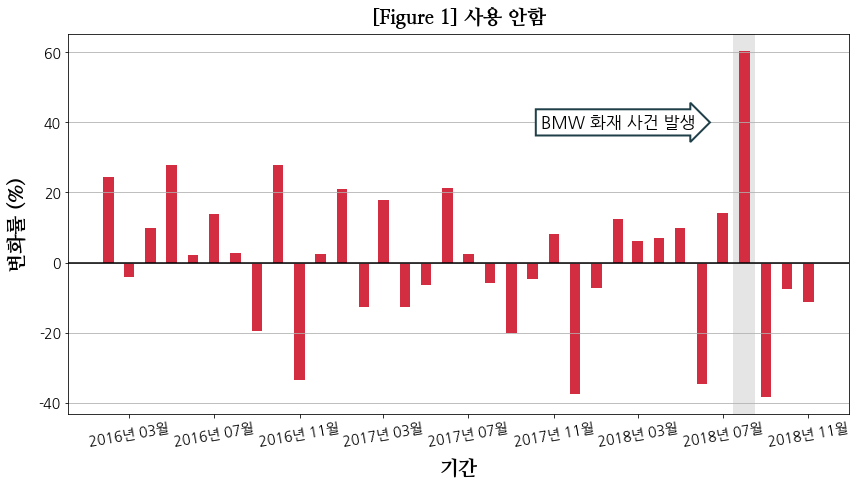

In [13]:
y_int = df_int['title'].groupby([df_int["time"].dt.year.rename('year'), df_int["time"].dt.month.rename('month')]).count().T.values

fig, ax = plt.subplots(1, 1, figsize = (14, 7))

ax.bar(x_bmw_date['date'].values, (y_int[1:] - y_int[:-1]) / y_int[1:] * 100, label = '수입차',
       width = 15, color = '#D32D41', zorder = 1)
ax.axvline(x = mdates.date2num(x_int_date['date'].values)[-4],
          color = 'gray', lw = 22, alpha = 0.2, zorder = 0)
ax.axhline(y = 0, color = 'k')

ax.set_title(r'[Figure 1] 사용 안함', fontsize = 20, fontname = myeongjo, pad = 10)
ax.set_xlabel('기간', fontsize = 20, fontname = myeongjo, labelpad = 10)
ax.set_ylabel('변화률 (%)', fontsize = 20, fontname = myeongjo, labelpad = 10)

ax.text(mdates.date2num(x_int_date['date'].values[-10]), 40,
        'BMW 화재 사건 발생', ha = 'center', va = 'center', rotation = 0, size = 17,
        bbox = dict(boxstyle = 'rarrow', fc = (1, 1, 1), ec = '#1F3F49', lw = 2))

ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.grid(axis = 'y')

plt.xticks(rotation = 10)
plt.show()

In [14]:
okt = Okt()

# 국산차게시판 데이터는 natCar
# 수입차게시판 데이터는 intCar
# 뉴스 데이터는 news

# 2018년 8, 9, 월
# 2018년 6, 7 월 로 나눔

before_natCar = list()
before_intCar = list()
before_news = list()
after_natCar = list()
after_intCar = list()
after_news = list()

for d in natCar:
    
    if datetime.strptime('2018-08-01', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-10-01', '%Y-%m-%d'):
        
        after_natCar.append(d)
        
    elif datetime.strptime('2018-06-01', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-08-01', '%Y-%m-%d'):
        
        before_natCar.append(d)
        
    else:
        
        pass
    
for d in intCar:
    
    if datetime.strptime('2018-08-01', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-10-01', '%Y-%m-%d'):
        
        after_intCar.append(d)
        
    elif datetime.strptime('2018-06-01', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-08-01', '%Y-%m-%d'):
        
        before_intCar.append(d)
        
    else:
        
        pass
    
for d in news:
    
    if datetime.strptime('2018-08-01', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-10-01', '%Y-%m-%d'):
        
        after_news.append(d)
        
    elif datetime.strptime('2018-06-01', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-08-01', '%Y-%m-%d'):
        
        before_news.append(d)
        
    else:
        
        pass

    
before_news_BMW = list()
after_news_BMW = list()

for d in news:
    
    if any(sb in d['content'] for sb in ['BMW', 'bmw', '비엠더블유']):
    
        if datetime.strptime('2018-08-01', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-10-01', '%Y-%m-%d'):

            after_news_BMW.append(d)

        elif datetime.strptime('2018-06-01', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-08-01', '%Y-%m-%d'):

            before_news_BMW.append(d)

        else:

            pass
    
def POS(string):
    
    result = list()
    
    temp = okt.pos(string, norm = True, stem = True)
    
    for t in temp:
        
        # 동사를 넣느냐 넣지 않느냐
        #if t[1] == 'Verb' or t[1] == 'Noun' or t[1] == 'Foreign' or t[1] == 'Adjective':
        #if (t[1] == 'Noun' or t[1] == 'Alpha' or t[1] == 'Adjective') and len(t[0]) > 1:
        if (t[1] == 'Noun' or t[1] == 'Alpha') and len(t[0]) > 1:
            
            result.append(t[0])
            
    return result

def top30word(data, n):
    
    doc = [d['title'].lower() + ' ' + d['content'].lower() for d in data]
    doc_POS = list(map(POS, doc))
    
    word_dict = set(list(itertools.chain.from_iterable(doc_POS)))
    word_dict = set([w for w in word_dict if len(w) > 1])
    
    word_count = {w:sum([d.count(w) for d in doc_POS]) for w in word_dict}
    word_count = sorted(word_count.items(), key = lambda kv : kv[1], reverse = True)

    for d in word_count[:n]:

        print(d)
        
    return doc_POS, word_dict, word_count

print('# of data (before_natCar) : ', len(before_natCar))
print('# of data (before_intCar) : ', len(before_intCar))
print('# of data (before_news)   : ', len(before_news))
print('# of data (after_natCar)  : ', len(after_natCar))
print('# of data (after_intCar)  : ', len(after_intCar))
print('# of data (after_news)    : ', len(after_news))

# of data (before_natCar) :  18336
# of data (before_intCar) :  2015
# of data (before_news)   :  792
# of data (after_natCar)  :  19052
# of data (after_intCar)  :  4708
# of data (after_news)    :  544


In [15]:
okt = Okt()

# 국산차게시판 데이터는 natCar
# 수입차게시판 데이터는 intCar
# 뉴스 데이터는 news

# 2018년 8, 9, 월
# 2018년 6, 7 월 로 나눔

before_natCar = list()
before_intCar = list()
before_news = list()
after_natCar = list()
after_intCar = list()
after_news = list()

for d in natCar:
    
    if datetime.strptime('2018-07-15', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-09-15', '%Y-%m-%d'):
        
        after_natCar.append(d)
        
    elif datetime.strptime('2018-05-15', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-07-15', '%Y-%m-%d'):
        
        before_natCar.append(d)
        
    else:
        
        pass
    
for d in intCar:
    
    if any(sb in d['content'] for sb in ['BMW', 'bmw', '비엠더블유']):
    
        if datetime.strptime('2018-07-15', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-09-15', '%Y-%m-%d'):

            after_intCar.append(d)

        elif datetime.strptime('2018-05-15', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-07-15', '%Y-%m-%d'):

            before_intCar.append(d)

        else:

            pass
    
for d in news:
    
    if datetime.strptime('2018-07-15', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-09-15', '%Y-%m-%d'):
        
        after_news.append(d)
        
    elif datetime.strptime('2018-05-15', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-07-15', '%Y-%m-%d'):
        
        before_news.append(d)
        
    else:
        
        pass

    
before_news_BMW = list()
after_news_BMW = list()

for d in news:
    
    if any(sb in d['content'] for sb in ['BMW', 'bmw', '비엠더블유']):
    
        if datetime.strptime('2018-07-15', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-09-15', '%Y-%m-%d'):

            after_news_BMW.append(d)

        elif datetime.strptime('2018-05-15', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-07-15', '%Y-%m-%d'):

            before_news_BMW.append(d)

        else:

            pass
    
def POS(string):
    
    result = list()
    
    temp = okt.pos(string, norm = True, stem = True)
    
    for t in temp:
        
        # 동사를 넣느냐 넣지 않느냐
        #if t[1] == 'Verb' or t[1] == 'Noun' or t[1] == 'Foreign' or t[1] == 'Adjective':
        #if (t[1] == 'Noun' or t[1] == 'Alpha' or t[1] == 'Adjective') and len(t[0]) > 1:
        #if (t[1] == 'Noun' or t[1] == 'Alpha') and len(t[0]) > 1:
        if t[1] == 'Noun' and len(t[0]) > 1:
            
            result.append(t[0])
            
    return result

def top30word(data, n):
    
    doc = [d['title'].lower() + ' ' + d['content'].lower() for d in data]
    doc_POS = list(map(POS, doc))
    
    word_dict = set(list(itertools.chain.from_iterable(doc_POS)))
    word_dict = set([w for w in word_dict if len(w) > 1])
    
    word_count = {w:sum([d.count(w) for d in doc_POS]) for w in word_dict}
    word_count = sorted(word_count.items(), key = lambda kv : kv[1], reverse = True)

    for d in word_count[:n]:

        print(d[0] + ' (' + str(d[1]) + ')')
        
    return doc_POS, word_dict, word_count

print('# of data (before_natCar) : ', len(before_natCar))
print('# of data (before_intCar) : ', len(before_intCar))
print('# of data (before_news)   : ', len(before_news))
print('# of data (after_natCar)  : ', len(after_natCar))
print('# of data (after_intCar)  : ', len(after_intCar))
print('# of data (after_news)    : ', len(after_news))

# of data (before_natCar) :  19146
# of data (before_intCar) :  100
# of data (before_news)   :  748
# of data (after_natCar)  :  19243
# of data (after_intCar)  :  301
# of data (after_news)    :  658


In [16]:
before_news_tagged = top30word(before_news_BMW, 30) # 동사 미포함

모델 (329)
브랜드 (222)
성능 (154)
자동차 (152)
엔진 (137)
차량 (134)
주행 (121)
마력 (119)
타이어 (119)
디자인 (114)
모터쇼 (114)
시장 (111)
시스템 (108)
적용 (101)
변속기 (100)
공개 (98)
벤츠 (98)
예정 (94)
통해 (94)
기술 (93)
출력 (91)
최고 (89)
그룹 (88)
판매 (88)
국내 (86)
세대 (82)
아우디 (80)
제공 (79)
탑재 (78)
토크 (76)


In [17]:
after_news_tagged = top30word(after_news_BMW, 30) # 동사 미포함

모델 (345)
차량 (173)
엔진 (142)
브랜드 (139)
자동차 (134)
리콜 (122)
소비자 (113)
적용 (109)
화재 (107)
예정 (102)
서비스 (102)
안전 (101)
진단 (96)
디자인 (94)
코리아 (93)
벤츠 (87)
디젤 (86)
위해 (85)
시장 (84)
판매 (84)
센터 (83)
통해 (83)
공장 (81)
성능 (81)
가격 (76)
클래스 (73)
메르세데스 (70)
시스템 (69)
때문 (69)
주행 (68)


In [18]:
before_intCar_tagged = top30word(before_intCar, 30) # 동사 미포함

차량 (119)
벤츠 (76)
모델 (58)
생각 (53)
정도 (50)
구매 (45)
운전 (38)
가격 (37)
자동차 (34)
수입 (33)
딜러 (30)
랭글러 (30)
주행 (29)
디젤 (28)
브랜드 (26)
할인 (25)
현재 (25)
센터 (25)
그냥 (25)
얘기 (24)
아우디 (24)
판매 (23)
클래스 (23)
사람 (22)
느낌 (22)
엔진 (21)
소리 (21)
가장 (21)
구입 (20)
추천 (20)


In [19]:
after_intCar_tagged = top30word(after_intCar, 30) # 동사 미포함

화재 (354)
차량 (322)
엔진 (173)
문제 (173)
리콜 (169)
벤츠 (169)
아우디 (143)
자동차 (138)
발생 (118)
생각 (116)
브랜드 (110)
때문 (100)
디젤 (99)
안전 (94)
서비스 (92)
센터 (91)
사고 (90)
결함 (86)
독일 (85)
사람 (81)
부품 (75)
이번 (75)
원인 (75)
지금 (75)
다른 (73)
회사 (71)
조사 (71)
진단 (69)
가격 (69)
정도 (68)


In [20]:
common_dictionary = gensim.corpora.dictionary.Dictionary(before_news_tagged[0])
common_corpus = [common_dictionary.doc2bow(text) for text in before_news_tagged[0]]

lda = gensim.models.ldamodel.LdaModel(common_corpus, num_topics = 4, id2word = common_dictionary, passes = 10)
topics = lda.print_topics(num_words = 8)
for topic in topics:
    print(topic)

(0, '0.020*"모델" + 0.011*"시스템" + 0.011*"마력" + 0.010*"엔진" + 0.009*"디자인" + 0.009*"적용" + 0.009*"출력" + 0.009*"공개"')
(1, '0.025*"브랜드" + 0.014*"모터쇼" + 0.014*"자동차" + 0.010*"벤츠" + 0.009*"가치" + 0.009*"부산" + 0.008*"아우디" + 0.008*"차량"')
(2, '0.018*"모델" + 0.009*"판매" + 0.007*"차량" + 0.007*"볼보" + 0.007*"가격" + 0.007*"성능" + 0.007*"제공" + 0.007*"서비스"')
(3, '0.016*"변속기" + 0.016*"타이어" + 0.013*"클러치" + 0.012*"성능" + 0.010*"듀얼" + 0.010*"모델" + 0.009*"효율" + 0.008*"자동차"')


In [21]:
common_dictionary = gensim.corpora.dictionary.Dictionary(after_news_tagged[0])
common_corpus = [common_dictionary.doc2bow(text) for text in after_news_tagged[0]]

lda = gensim.models.ldamodel.LdaModel(common_corpus, num_topics = 4, id2word = common_dictionary, passes = 10)
topics = lda.print_topics(num_words = 8)
for topic in topics:
    print(topic)

(0, '0.014*"리콜" + 0.013*"모델" + 0.012*"진단" + 0.011*"안전" + 0.011*"화재" + 0.010*"예정" + 0.010*"차량" + 0.009*"서비스"')
(1, '0.025*"모델" + 0.012*"자동차" + 0.010*"디자인" + 0.008*"브랜드" + 0.008*"현대" + 0.008*"판매량" + 0.007*"시장" + 0.007*"판매"')
(2, '0.011*"차량" + 0.010*"모델" + 0.009*"공장" + 0.008*"센터" + 0.008*"적용" + 0.007*"프로그램" + 0.006*"코리아" + 0.006*"엔진"')
(3, '0.015*"소비자" + 0.014*"브랜드" + 0.014*"모델" + 0.011*"디젤" + 0.010*"제네시스" + 0.010*"고급" + 0.007*"가치" + 0.007*"기아차"')


In [22]:
common_dictionary = gensim.corpora.dictionary.Dictionary(before_intCar_tagged[0])
common_corpus = [common_dictionary.doc2bow(text) for text in before_intCar_tagged[0]]

lda = gensim.models.ldamodel.LdaModel(common_corpus, num_topics = 4, id2word = common_dictionary, passes = 10)
topics = lda.print_topics(num_words = 8)
for topic in topics:
    print(topic)

(0, '0.012*"벤츠" + 0.012*"구매" + 0.011*"수입" + 0.009*"판매" + 0.009*"할인" + 0.008*"차량" + 0.008*"클래스" + 0.008*"판매량"')
(1, '0.016*"벤츠" + 0.013*"차량" + 0.010*"가격" + 0.008*"생각" + 0.008*"모터쇼" + 0.008*"모델" + 0.007*"현재" + 0.007*"자동차"')
(2, '0.021*"차량" + 0.011*"정도" + 0.008*"운전" + 0.007*"주행" + 0.007*"브랜드" + 0.006*"생각" + 0.006*"디젤" + 0.006*"운전자"')
(3, '0.016*"차량" + 0.014*"모델" + 0.014*"랭글러" + 0.008*"생각" + 0.008*"적용" + 0.008*"구안" + 0.007*"뉴티" + 0.006*"얘기"')


In [23]:
common_dictionary = gensim.corpora.dictionary.Dictionary(after_intCar_tagged[0])
common_corpus = [common_dictionary.doc2bow(text) for text in after_intCar_tagged[0]]

lda = gensim.models.ldamodel.LdaModel(common_corpus, num_topics = 4, id2word = common_dictionary, passes = 10)
topics = lda.print_topics(num_words = 8)
for topic in topics:
    print(topic)

(0, '0.021*"화재" + 0.013*"차량" + 0.012*"문제" + 0.010*"벤츠" + 0.008*"브랜드" + 0.008*"리콜" + 0.008*"자동차" + 0.008*"엔진"')
(1, '0.015*"아우디" + 0.010*"디자인" + 0.010*"서비스" + 0.010*"벤츠" + 0.009*"센터" + 0.008*"차량" + 0.008*"부문" + 0.007*"안전"')
(2, '0.017*"화재" + 0.017*"차량" + 0.011*"리콜" + 0.007*"생각" + 0.007*"문제" + 0.006*"사고" + 0.006*"한국" + 0.005*"디젤"')
(3, '0.019*"엔진" + 0.012*"차량" + 0.007*"자료" + 0.007*"고장" + 0.006*"관련" + 0.006*"화재" + 0.006*"센터" + 0.005*"점검"')
